
# Calibration NN + Heston (Carr-Madan FFT, PyTorch)

Inputs per sample: [r, T, S0, K, iv_BS].  
Network outputs: (kappa, theta, sigma, rho, v0).  
Loss: Vega-weighted MSE between Heston price and market price.  
Stabilization: Little Heston Trap, Feller penalty.

Goal: end-to-end differentiable calibration of Heston via a conditional NN and an FFT pricing layer.


In [8]:

# pip install torch --upgrade
import torch
import torch.nn as nn
import torch.nn.functional as F

# Optional: diagnostics
import math
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [9]:

# ---------------- Black-Scholes utils ----------------

def _ncdf(x):
    return 0.5*(1.0 + torch.erf(x / math.sqrt(2.0)))

def bs_call(S0, K, T, r, q, vol):
    # vectorized torch implementation
    eps = torch.tensor(1e-12, dtype=S0.dtype, device=S0.device)
    S0, K, T, r, q, vol = map(lambda t: t.to(S0.dtype), (S0, K, T, r, q, vol))
    d1 = (torch.log(S0/K) + (r - q + 0.5*vol*vol)*T) / (vol*torch.sqrt(T+eps) + eps)
    d2 = d1 - vol*torch.sqrt(T+eps)
    return S0*torch.exp(-q*T)*_ncdf(d1) - K*torch.exp(-r*T)*_ncdf(d2)

def bs_vega(S0, K, T, r, q, vol):
    # Vega = S0 * exp(-qT) * phi(d1) * sqrt(T)
    eps = torch.tensor(1e-12, dtype=S0.dtype, device=S0.device)
    d1 = (torch.log(S0/K) + (r - q + 0.5*vol*vol)*T) / (vol*torch.sqrt(T+eps) + eps)
    phi = torch.exp(-0.5*d1*d1) / math.sqrt(2.0*math.pi)
    return S0*torch.exp(-q*T)*phi*torch.sqrt(T+eps)


In [10]:

# =========================
# Torch Heston + Carr-Madan
# =========================

class HestonPricingLayer(nn.Module):
    '''
    Differentiable. Vectorized over batch.
    Carr-Madan FFT with Little Heston Trap.
    '''
    def __init__(self, N=4096, eta=0.25, alpha=1.5):
        super().__init__()
        if N % 2 != 0:
            raise ValueError("N must be even.")
        if alpha <= 0:
            raise ValueError("alpha must be > 0.")
        self.N = N
        self.eta = eta
        self.alpha = alpha

        # Frequency grid and Simpson weights
        n = torch.arange(N, dtype=torch.float64)
        v = eta * n
        w = torch.ones(N, dtype=torch.float64)
        w[1:N-1:2] = 4.0
        w[2:N-2:2] = 2.0
        w = w * (eta / 3.0)

        self.register_buffer("v", v)
        self.register_buffer("w", w)

        dk = 2.0 * torch.pi / (N * eta)
        b  = 0.5 * N * dk
        self.dk = dk
        self.b  = b

    def _heston_cf(self, u, T, S0, r, q, kappa, theta, sigma, rho, v0):
        i = torch.complex(torch.tensor(0., dtype=torch.float64, device=u.device),
                          torch.tensor(1., dtype=torch.float64, device=u.device))
        x0 = torch.log(S0)

        a = kappa * theta
        b = kappa - rho * sigma * i * u
        d = torch.sqrt(b*b + (sigma**2) * (u*u + i*u))

        g = (b - d) / (b + d)
        # Trap: enforce |g|<1
        mask = (g.abs() >= 1.0)
        g = torch.where(mask, 1.0 / g, g)

        eDT = torch.exp(-d * T)
        one_minus_g = 1.0 - g
        one_minus_g_eDT = 1.0 - g * eDT

        eps = torch.tensor(1e-15, dtype=torch.float64, device=u.device)
        one_minus_g = torch.where(one_minus_g.abs() < eps, eps, one_minus_g)
        one_minus_g_eDT = torch.where(one_minus_g_eDT.abs() < eps, eps, one_minus_g_eDT)

        C = i*u*(r - q)*T + (a/(sigma**2)) * ((b - d)*T - 2.0*torch.log(one_minus_g_eDT/one_minus_g))
        D = ((b - d)/(sigma**2)) * ((1.0 - eDT)/one_minus_g_eDT)

        return torch.exp(C + D*v0 + i*u*x0)

    def forward(self, S0, K, T, r, q, kappa, theta, sigma, rho, v0):
        device = S0.device
        dtype  = torch.float64

        v = self.v.to(device=device)
        w = self.w.to(device=device)
        N = self.N
        alpha = torch.as_tensor(self.alpha, dtype=dtype, device=device)

        i = torch.complex(torch.tensor(0., dtype=dtype, device=device),
                          torch.tensor(1., dtype=dtype, device=device))
        u_shift = v - (alpha + 1.0)*i  # (N,) complex

        B = S0.shape[0]
        u = u_shift.unsqueeze(0).expand(B, N)

        # Cast
        S0 = S0.to(dtype); K = K.to(dtype); T = T.to(dtype)
        r = r.to(dtype);   q = q.to(dtype)
        kappa = kappa.to(dtype); theta = theta.to(dtype)
        sigma = sigma.to(dtype); rho = rho.to(dtype); v0 = v0.to(dtype)

        phi_shift = self._heston_cf(u, T[:,None], S0[:,None], r[:,None], q[:,None],
                                    kappa[:,None], theta[:,None], sigma[:,None],
                                    rho[:,None], v0[:,None])  # (B,N)

        denom = (alpha**2 + alpha - v**2 + (2*alpha + 1.0)*i*v)
        denom = torch.where(denom.abs() < 1e-30,
                            torch.complex(torch.tensor(1e-30, dtype=dtype, device=device),
                                          torch.tensor(0., dtype=dtype, device=device)),
                            denom)

        psi = torch.exp(-r[:,None]*T[:,None]) * phi_shift / denom

        dk = torch.as_tensor(self.dk, dtype=dtype, device=device)
        b  = torch.as_tensor(self.b, dtype=dtype, device=device)

        x  = psi * torch.exp(1j * b * v) * w  # (B,N)

        F = torch.fft.fft(x, dim=-1).real  # (B,N)

        j = torch.arange(N, dtype=dtype, device=device)
        k_grid = -b + j * dk
        calls_grid = torch.exp(-alpha * k_grid)[None, :] / torch.pi * F  # (B,N)

        # Linear interp in log-strike
        k_target = torch.log(K).to(dtype)
        pos = (k_target + b) / dk
        idx1 = torch.clamp(pos.floor().long(), 0, N-2)
        idx2 = idx1 + 1

        k0 = k_grid[idx1]
        k1 = k_grid[idx2]
        c0 = calls_grid.gather(1, idx1.view(-1,1)).squeeze(1)
        c1 = calls_grid.gather(1, idx2.view(-1,1)).squeeze(1)
        w1 = (k_target - k0) / (k1 - k0 + 1e-16)
        price = c0 + (c1 - c0) * w1
        return price


In [11]:

# =============
# Neural network
# =============

class HestonCalibrator(nn.Module):
    '''
    NN -> Heston params -> pricing layer -> call price.
    Input (B,5): [r, T, S0, K, iv_bs]
    '''
    def __init__(self, hidden=128, N=4096, eta=0.25, alpha=1.5):
        super().__init__()
        self.feature_net = nn.Sequential(
            nn.Linear(5, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 6)  # kappa, theta, sigma, rho, v0, q_shift (optional)
        )
        self.pricer = HestonPricingLayer(N=N, eta=eta, alpha=alpha)

        # Xavier init
        for m in self.feature_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

        # Seed output biases for plausible starting values
        with torch.no_grad():
            self.feature_net[-1].bias[:] = torch.tensor([ 0.7,   # kappa ~ 1+
                                                          -3.2,  # theta ~ 0.04
                                                          -0.7,  # sigma ~ 0.33
                                                           0.0,  # rho ~ 0
                                                          -3.2,  # v0   ~ 0.04
                                                           0.0], dtype=torch.float64)

    def forward(self, x, C_mkt=None):
        r, T, S0, K, iv = x.unbind(dim=1)
        raw = self.feature_net(x)

        raw_kappa, raw_theta, raw_sigma, raw_rho, raw_v0, raw_qshift = raw.unbind(dim=1)

        softplus = torch.nn.functional.softplus
        kappa = softplus(raw_kappa) + 1e-6
        theta = softplus(raw_theta) + 1e-8
        sigma = softplus(raw_sigma) + 1e-8
        rho   = 0.999 * torch.tanh(raw_rho)
        v0    = softplus(raw_v0) + 1e-10
        q     = torch.zeros_like(r)  # keep q=0 here

        C_pred = self.pricer(S0, K, T, r, q, kappa, theta, sigma, rho, v0)

        out = {"kappa": kappa, "theta": theta, "sigma": sigma, "rho": rho, "v0": v0, "C_pred": C_pred}
        if C_mkt is None:
            return out
        loss = torch.nn.functional.mse_loss(C_pred, C_mkt)
        out["loss"] = loss
        return out


In [12]:

# -------------- Losses and penalties --------------

def weighted_mse(C_pred, C_mkt, vega, eps=1e-8):
    w = 1.0 / (vega.abs() + eps)
    diff = C_pred - C_mkt
    return torch.mean((w * diff)**2)

def feller_penalty(kappa, theta, sigma):
    # Feller: 2*kappa*theta >= sigma^2
    return torch.relu(sigma*sigma - 2.0*kappa*theta)

def train_step(model, optimizer, batch_x, batch_Cmkt, lambda_feller=1e-3, lambda_ridge=1e-6):
    model.train()
    optimizer.zero_grad()

    out = model(batch_x, C_mkt=batch_Cmkt)
    C_pred = out["C_pred"]

    r, T, S0, K, iv = batch_x.unbind(dim=1)
    vega = bs_vega(S0, K, T, r, torch.zeros_like(r), iv)

    mse = weighted_mse(C_pred, batch_Cmkt, vega)
    pen_feller = feller_penalty(out["kappa"], out["theta"], out["sigma"]).mean()
    pen_ridge  = (out["kappa"].mean() + out["theta"].mean() + out["sigma"].mean()
                  + out["v0"].mean() + out["rho"].pow(2).mean())

    loss = mse + lambda_feller*pen_feller + lambda_ridge*pen_ridge
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    optimizer.step()

    return {"loss": loss.detach(), "mse": mse.detach(), "feller": pen_feller.detach()}


In [13]:
# ======================
# Synthetic demo dataset
# ======================

B = 256
S0 = torch.full((B,), 100.0, device=device)
K  = torch.linspace(60.0, 140.0, B, device=device)
T  = torch.linspace(0.25, 2.0, B, device=device)
r  = torch.full((B,), 0.01, device=device)
q  = torch.zeros(B, device=device)
iv = torch.full((B,), 0.20, device=device)

C_mkt = bs_call(S0, K, T, r, q, iv).detach()
X = torch.stack([r, T, S0, K, iv], dim=1).to(device)

model = HestonCalibrator(hidden=128, N=2048, eta=0.20, alpha=1.5).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    stats = train_step(model, opt, X, C_mkt, lambda_feller=5e-4, lambda_ridge=1e-6)
    print(f"epoch {epoch+1:02d} | loss {stats['loss'].item():.6e} | "
          f"mse {stats['mse'].item():.6e} | feller {stats['feller'].item():.3e}")


epoch 01 | loss inf | mse inf | feller 2.221e+01
epoch 02 | loss nan | mse nan | feller nan
epoch 03 | loss nan | mse nan | feller nan
epoch 04 | loss nan | mse nan | feller nan
epoch 05 | loss nan | mse nan | feller nan
epoch 06 | loss nan | mse nan | feller nan
epoch 07 | loss nan | mse nan | feller nan
epoch 08 | loss nan | mse nan | feller nan
epoch 09 | loss nan | mse nan | feller nan
epoch 10 | loss nan | mse nan | feller nan


kappa nan
theta nan
sigma nan
rho nan
v0 nan


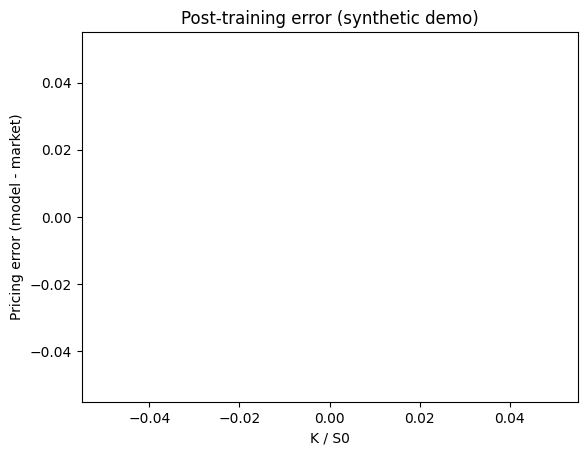

In [14]:

with torch.no_grad():
    out = model(X)
    for k in ["kappa","theta","sigma","rho","v0"]:
        print(k, out[k].mean().item())

    C_pred = out["C_pred"]
    atm_idx = (torch.abs(torch.log(K/S0)) < 1e-3).nonzero(as_tuple=True)[0]
    if len(atm_idx) > 0:
        i0 = atm_idx[0].item()
        print("ATM sample: S0=", S0[i0].item(), "K=", K[i0].item(), "T=", T[i0].item())
        put_parity = C_pred[i0] - S0[i0]*torch.exp(-q[i0]*T[i0]) + K[i0]*torch.exp(-r[i0]*T[i0])
        print("Parity put (model):", put_parity.item())

# Error plot vs K/S0
err = (C_pred - C_mkt).detach().cpu()
k_rel = (K/S0).detach().cpu()

plt.figure()
plt.plot(k_rel.numpy(), err.numpy(), marker='o', linestyle='None')
plt.xlabel('K / S0')
plt.ylabel('Pricing error (model - market)')
plt.title('Post-training error (synthetic demo)')
plt.show()



## Load your real market data

Expected columns: ['r','T','S0','K','iv_bs','C_mkt']

Example:
```python
# df = pd.read_csv('your_quotes.csv')
r  = torch.tensor(df['r'    ].values, dtype=torch.float64, device=device)
T  = torch.tensor(df['T'    ].values, dtype=torch.float64, device=device)
S0 = torch.tensor(df['S0'   ].values, dtype=torch.float64, device=device)
K  = torch.tensor(df['K'    ].values, dtype=torch.float64, device=device)
iv = torch.tensor(df['iv_bs'].values, dtype=torch.float64, device=device)
C_mkt = torch.tensor(df['C_mkt'].values, dtype=torch.float64, device=device)

X = torch.stack([r,T,S0,K,iv], dim=1)
# Then reuse the training loop with mini-batches
```
